In [1]:
from pathlib import Path
import numpy as np
import lsstypes as types
from clustering_statistics.tools import get_stats_fn

stats_dir = Path('/global/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/desipipe')

You can have a look at [lsstypes](https://github.com/adematti/lsstypes/tree/main/nb) notebooks.

## Holi mocks v1

### Power spectrum

In [2]:
fn = get_stats_fn(stats_dir=stats_dir, kind='mesh2_spectrum', version='holi-v1-altmtl', tracer='LRG',
                  zrange=(0.4, 0.6), region='GCcomb', weight='default_FKP', imock=459)
fn

PosixPath('/global/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/desipipe/holi-v1-altmtl/mesh2_spectrum_poles_LRG_z0.4-0.6_GCcomb_default_FKP_459.h5')

In [3]:
spectrum = types.read(fn)
print(spectrum, f"with k-average: {spectrum.get(ells=0).coords('k')}")

Mesh2SpectrumPoles(labels=[{'ells': 0}, {'ells': 2}, {'ells': 4}], size=1254) with k-average: [0.         0.00158216 0.00257437 0.00350089 0.00453571 0.005505
 0.0064685  0.00753006 0.00846034 0.00944034 0.01044992 0.01147719
 0.01251408 0.01352767 0.01452492 0.01550576 0.01650614 0.01749741
 0.01847575 0.01946183 0.02048392 0.02149681 0.02247801 0.02350894
 0.02451968 0.02548584 0.02648757 0.02749224 0.02849052 0.02948953
 0.03050037 0.03150198 0.03249394 0.03350734 0.03451511 0.03550646
 0.03650478 0.03750108 0.03850312 0.03949886 0.04049062 0.04149582
 0.04250629 0.04351068 0.04450394 0.04549905 0.04650836 0.04751106
 0.04849677 0.0494962  0.05050318 0.05150135 0.05250725 0.05350968
 0.05450168 0.05549592 0.05649516 0.0574972  0.05850652 0.05950274
 0.06050596 0.06150776 0.06250605 0.06350608 0.06450504 0.06550948
 0.06649948 0.06749584 0.06849518 0.06950311 0.07050201 0.07150105
 0.07250796 0.07350524 0.07450288 0.075505   0.07650112 0.07749599
 0.07849937 0.07950575 0.08050952 0.0

In [4]:
spectrum = spectrum.select(k=slice(0, None, 5))  # rebin to dk = 0.005 h/Mpc
spectrum = spectrum.select(k=(0., 0.4))  # select k-range
spectrum = spectrum.get(ells=[0, 2])  # monopole and quadrupole
spectrum = spectrum.at(ells=[2]).select(k=(0., 0.3))  # apply stricter k-cut to the quadrupole

for ell in spectrum.ells:
    pole = spectrum.get(ell)
    pole.coords('k')  # k-modes
    pole.value()  # value of the power spectrum multipole
    #print(pole.values('shotnoise'))  # shotnoise

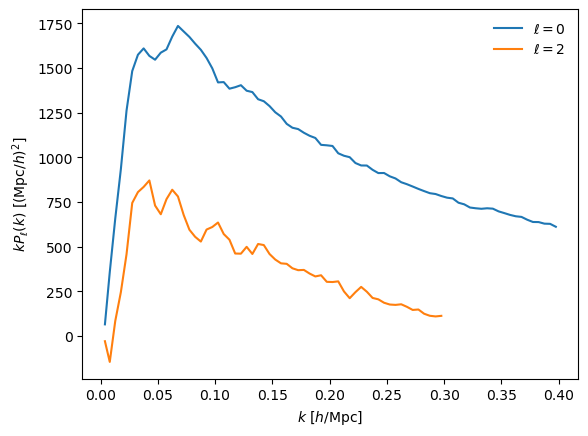

In [5]:
spectrum.plot(show=True);

### Combining NGC and SGC
The above region = GCcomb measurement is the (weighted) sum of the NGC and SGC power spectrum measurements.

In [6]:
kw = dict(version='holi-v1-altmtl', tracer='LRG', zrange=(0.4, 0.6), weight='default_FKP')
fns = [get_stats_fn(stats_dir=stats_dir, kind='mesh2_spectrum', **kw, region=region, imock=459) for region in ['NGC', 'SGC']]
combined = types.sum([types.read(fn) for fn in fns])  # also works for the bispectrum

ref = types.read(get_stats_fn(stats_dir=stats_dir, kind='mesh2_spectrum', **kw, region='GCcomb', imock=459))
assert np.allclose(combined.value(), ref.value())

### $\theta$-cut, angular upweights

In [7]:
kw = dict(version='holi-v1-altmtl', tracer='LRG', zrange=(0.4, 0.6), region='GCcomb', weight='default_FKP')
fn = get_stats_fn(stats_dir=stats_dir, kind='mesh2_spectrum', **kw, cut=True, imock=459)  # provide theta-cut or angular upweights
types.read(fn)

Mesh2SpectrumPoles(labels=[{'ells': 0}, {'ells': 2}, {'ells': 4}], size=1254)

In [8]:
# Do not forget the 'basis' argument
fn = get_stats_fn(stats_dir=stats_dir, kind='mesh3_spectrum', basis='sugiyama-diagonal', **kw, imock=459)
bispectrum = types.read(fn)
bispectrum

Mesh3SpectrumPoles(labels=[{'ells': (0, 0, 0)}, {'ells': (2, 0, 2)}], size=82)

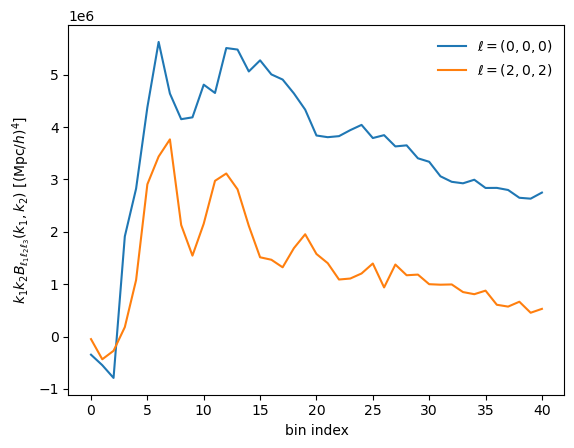

In [9]:
bispectrum.plot(show=True);

In [10]:
# All available mocks
fns = [get_stats_fn(stats_dir=stats_dir, kind='mesh2_spectrum', **kw, imock=imock) for imock in range(1000)]
fns = [fn for fn in fns if fn.exists()]
# Equivalently
fns = get_stats_fn(stats_dir=stats_dir, kind='mesh2_spectrum', **kw, imock='*')
print(len(fns))

221


In [11]:
covariance = types.cov([types.read(fn) for fn in fns])  # estimate covariance matrix

In [12]:
covariance = covariance.at.observable.match(spectrum)  # rebin to power spectrum
assert covariance.shape[0] == spectrum.size

In [13]:
covariance.value()  # to get covariance estimate

array([[ 1.35867341e+08,  5.45403273e+07,  1.06334250e+07, ...,
         2.87679775e+04,  1.24450820e+04,  1.17570715e+04],
       [ 5.45403273e+07,  6.82604869e+07,  1.73836625e+07, ...,
        -2.54363435e+04, -1.44131454e+04, -1.03174760e+04],
       [ 1.06334250e+07,  1.73836625e+07,  3.19454457e+07, ...,
        -1.04397280e+04, -2.06844154e+04, -2.13376033e+04],
       ...,
       [ 2.87679775e+04, -2.54363435e+04, -1.04397280e+04, ...,
         2.97292920e+03,  1.36847533e+03,  5.55282327e+02],
       [ 1.24450820e+04, -1.44131454e+04, -2.06844154e+04, ...,
         1.36847533e+03,  2.45723758e+03,  1.46768113e+03],
       [ 1.17570715e+04, -1.03174760e+04, -2.13376033e+04, ...,
         5.55282327e+02,  1.46768113e+03,  2.67576419e+03]])

## Joint data vector

In [14]:
from lsstypes import ObservableTree

observables = []
for imock in range(1000):
    kw = dict(stats_dir=stats_dir, version='holi-v1-altmtl', tracer='LRG',
              zrange=(0.4, 0.6), region='GCcomb', weight='default_FKP', imock=imock)
    fn2 = get_stats_fn(kind='mesh2_spectrum', **kw)
    fn3 = get_stats_fn(kind='mesh3_spectrum', basis='sugiyama-diagonal', **kw)
    if fn2.exists():
        spectrum2, spectrum3 = types.read(fn2), types.read(fn3)
        # Can choose any observables names
        tree = ObservableTree([spectrum2, spectrum3], observables=['spectrum2', 'spectrum3'])
        observables.append(tree)

covariance = types.cov(observables)

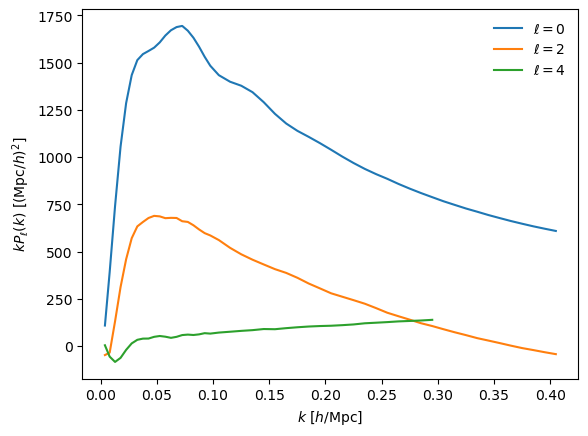

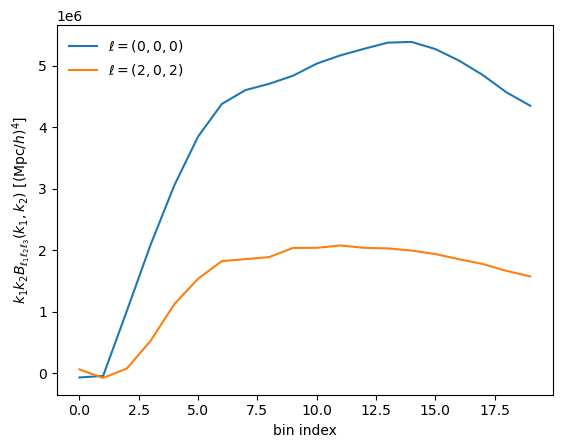

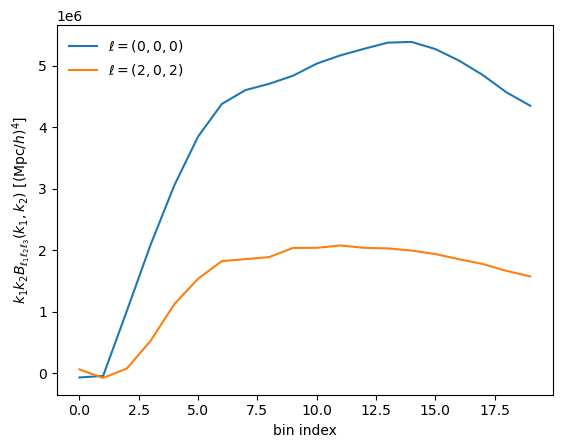

In [15]:
observable = covariance.observable
# Rebin power spectrum to dk = 0.005 h/Mpc
spectrum2 = observable.get(observables='spectrum2')
spectrum2 = spectrum2.select(k=slice(0, None, 5))
# Rebin by an extra factor 2 beyond k > 0.1 h/Mpc
for ell in spectrum2.ells:
    spectrum2 = spectrum2.at(ell).at(k=(0.1, 0.5)).select(k=slice(0, None, 2))
# Cut the hexadecapole
spectrum2 = spectrum2.at(ells=4).select(k=(0., 0.3))
# Select bispectrum
spectrum3 = observable.get(observables='spectrum3')
spectrum3 = spectrum3.select(k=(0., 0.1))
# Cut the quadrupole
spectrum3 = spectrum3.at(ells=[(2, 0, 2)]).select(k=(0., 0.1))
# Propagate to observable
observable = observable.at(observables='spectrum2').match(spectrum2)
observable = observable.at(observables='spectrum3').match(spectrum3)

observable.get(observables='spectrum2').plot(show=True)
observable.get(observables='spectrum3').plot(show=True)

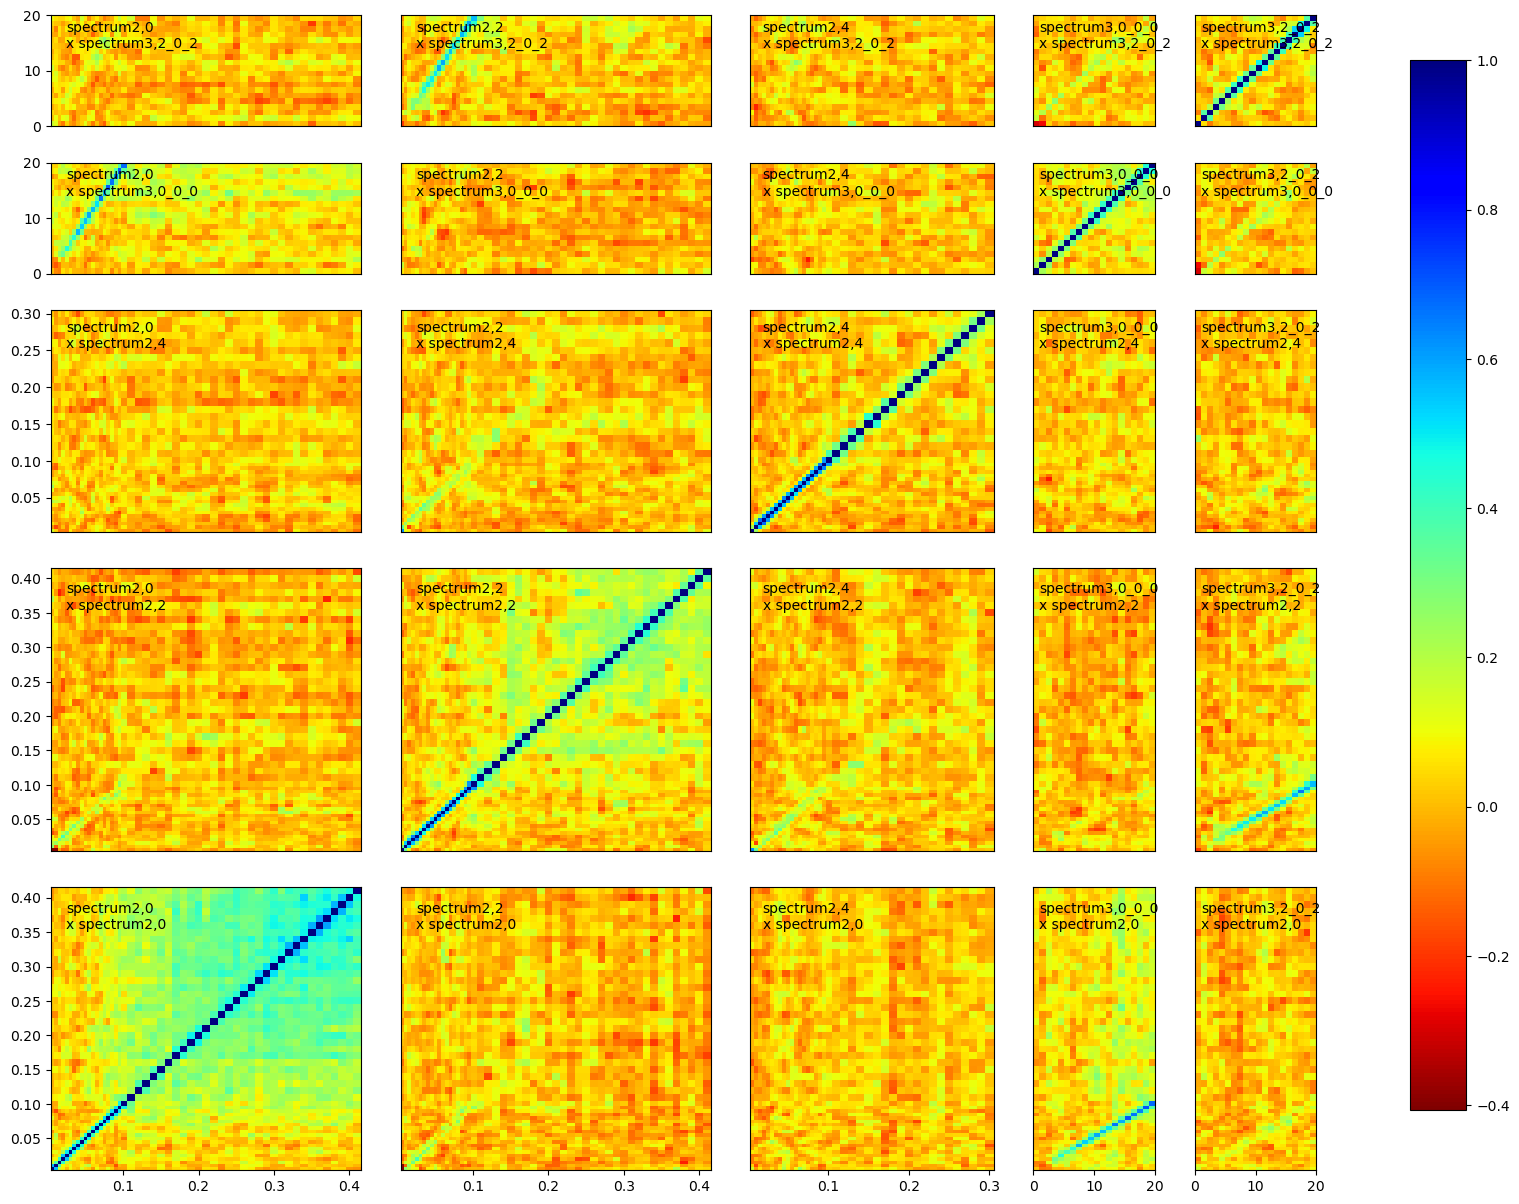

In [16]:
covariance = covariance.at.observable.match(observable)  # propagate to covariance matrix
covariance.plot(corrcoef=True, show=True);

## Abacus 2ndgen mocks

In [17]:
# 25 of them
fn = get_stats_fn(stats_dir=stats_dir, kind='mesh2_spectrum', version='abacus-2ndgen-complete', tracer='LRG',
                  zrange=(0.4, 0.6), region='NGC', weight='default_FKP', imock=12)

In [18]:
types.read(fn)

Mesh2SpectrumPoles(labels=[{'ells': 0}, {'ells': 2}, {'ells': 4}], size=1254)

In [19]:
# Window matrix
fn = get_stats_fn(stats_dir=stats_dir, kind='window_mesh2_spectrum', version='abacus-2ndgen-complete', tracer='LRG',
                  zrange=(0.4, 0.6), region='NGC', weight='default_FKP', imock=0)
window = types.read(fn)

In [20]:
window.observable

Mesh2SpectrumPoles(labels=[{'ells': 0}, {'ells': 2}, {'ells': 4}], size=1254)

In [21]:
window = window.at.observable.match(spectrum)  # match observed power spectrum
assert window.shape[0] == spectrum.size

In [22]:
window = window.at.theory.select(k=(0, 0.3))
for pole in window.theory:
    pole.coords('k')  # theory k's
window.value()  # window matrix 2D array
zeff = window.observable.get(ells=0).attrs['zeff']